# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')



### Data Loading

In [4]:
df =pd.read_csv("exams.csv")

In [5]:
df.shape

(1000, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [7]:
df.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,67.810000,70.382000,69.140000
std,15.250196,14.107413,15.025917
min,15.000000,25.000000,15.000000
25%,58.000000,61.000000,59.000000
50%,68.000000,70.500000,70.000000
75%,79.250000,80.000000,80.000000
max,100.000000,100.000000,100.000000


In [8]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

### Data Preprocessing

In [9]:
print("\n--- Data Preprocessing ---")
# Clean column names by stripping whitespace, converting to lowercase, and replacing spaces with underscores
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("Column names cleaned.")

# Create the 'pass' column
# A student 'passes' if all three scores (math, reading, writing) are 40 or above.
# This threshold is chosen based on a common arbitrary passing score for demonstration,
# and would typically be defined by business rules or academic standards.
df["pass"] = ((df["math_score"] >= 40) & (df["reading_score"] >= 40) & (df["writing_score"] >= 40)).astype(int)
print("Created 'pass' column based on score >= 40 for all subjects.")

# Display basic information and statistics
print("\nDataFrame Info:")
df.info()
print("\nDataFrame Description:")
print(df.describe().T)
print("\nFirst 5 rows of the DataFrame:")
print(df.head())
print("\nCheck for missing values:")
print(df.isnull().sum())


--- Data Preprocessing ---
Column names cleaned.
Created 'pass' column based on score >= 40 for all subjects.

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental_level_of_education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test_preparation_course      1000 non-null   object
 5   math_score                   1000 non-null   int64 
 6   reading_score                1000 non-null   int64 
 7   writing_score                1000 non-null   int64 
 8   pass                         1000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 70.4+ KB

DataFrame Description:
                count    mean        std   min   25%   50%    75%

### Exploratory Data Analysis (EDA)


--- Exploratory Data Analysis (EDA) ---


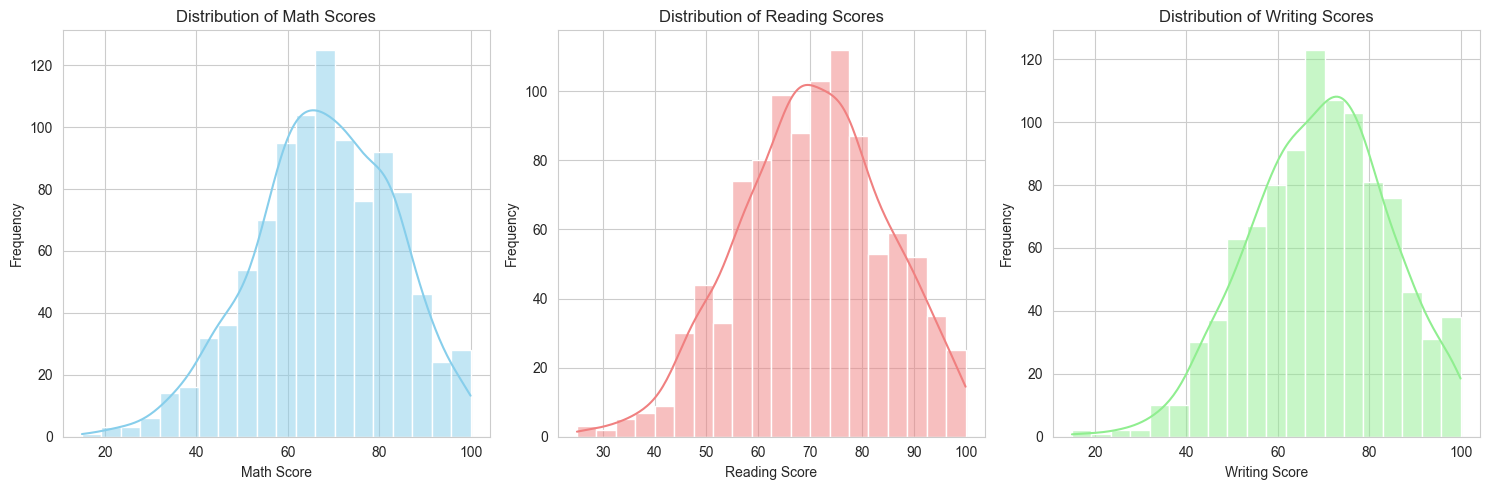

In [10]:
print("\n--- Exploratory Data Analysis (EDA) ---")

# Set style for plots
sns.set_style("whitegrid")
plt.figure(figsize=(15, 5))

# Distribution of numerical scores (Math, Reading, Writing)
plt.subplot(1, 3, 1)
sns.histplot(df['math_score'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Math Scores')
plt.xlabel('Math Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df['reading_score'], kde=True, bins=20, color='lightcoral')
plt.title('Distribution of Reading Scores')
plt.xlabel('Reading Score')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(df['writing_score'], kde=True, bins=20, color='lightgreen')
plt.title('Distribution of Writing Scores')
plt.xlabel('Writing Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


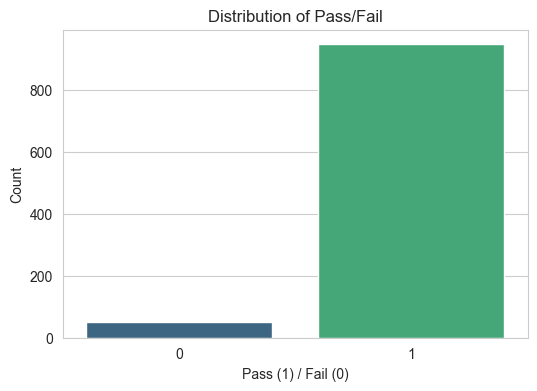

In [11]:
# Distribution of the 'pass' column (target variable)
plt.figure(figsize=(6, 4))
sns.countplot(x='pass', data=df, palette='viridis')
plt.title('Distribution of Pass/Fail')
plt.xlabel('Pass (1) / Fail (0)')
plt.ylabel('Count')
plt.show()

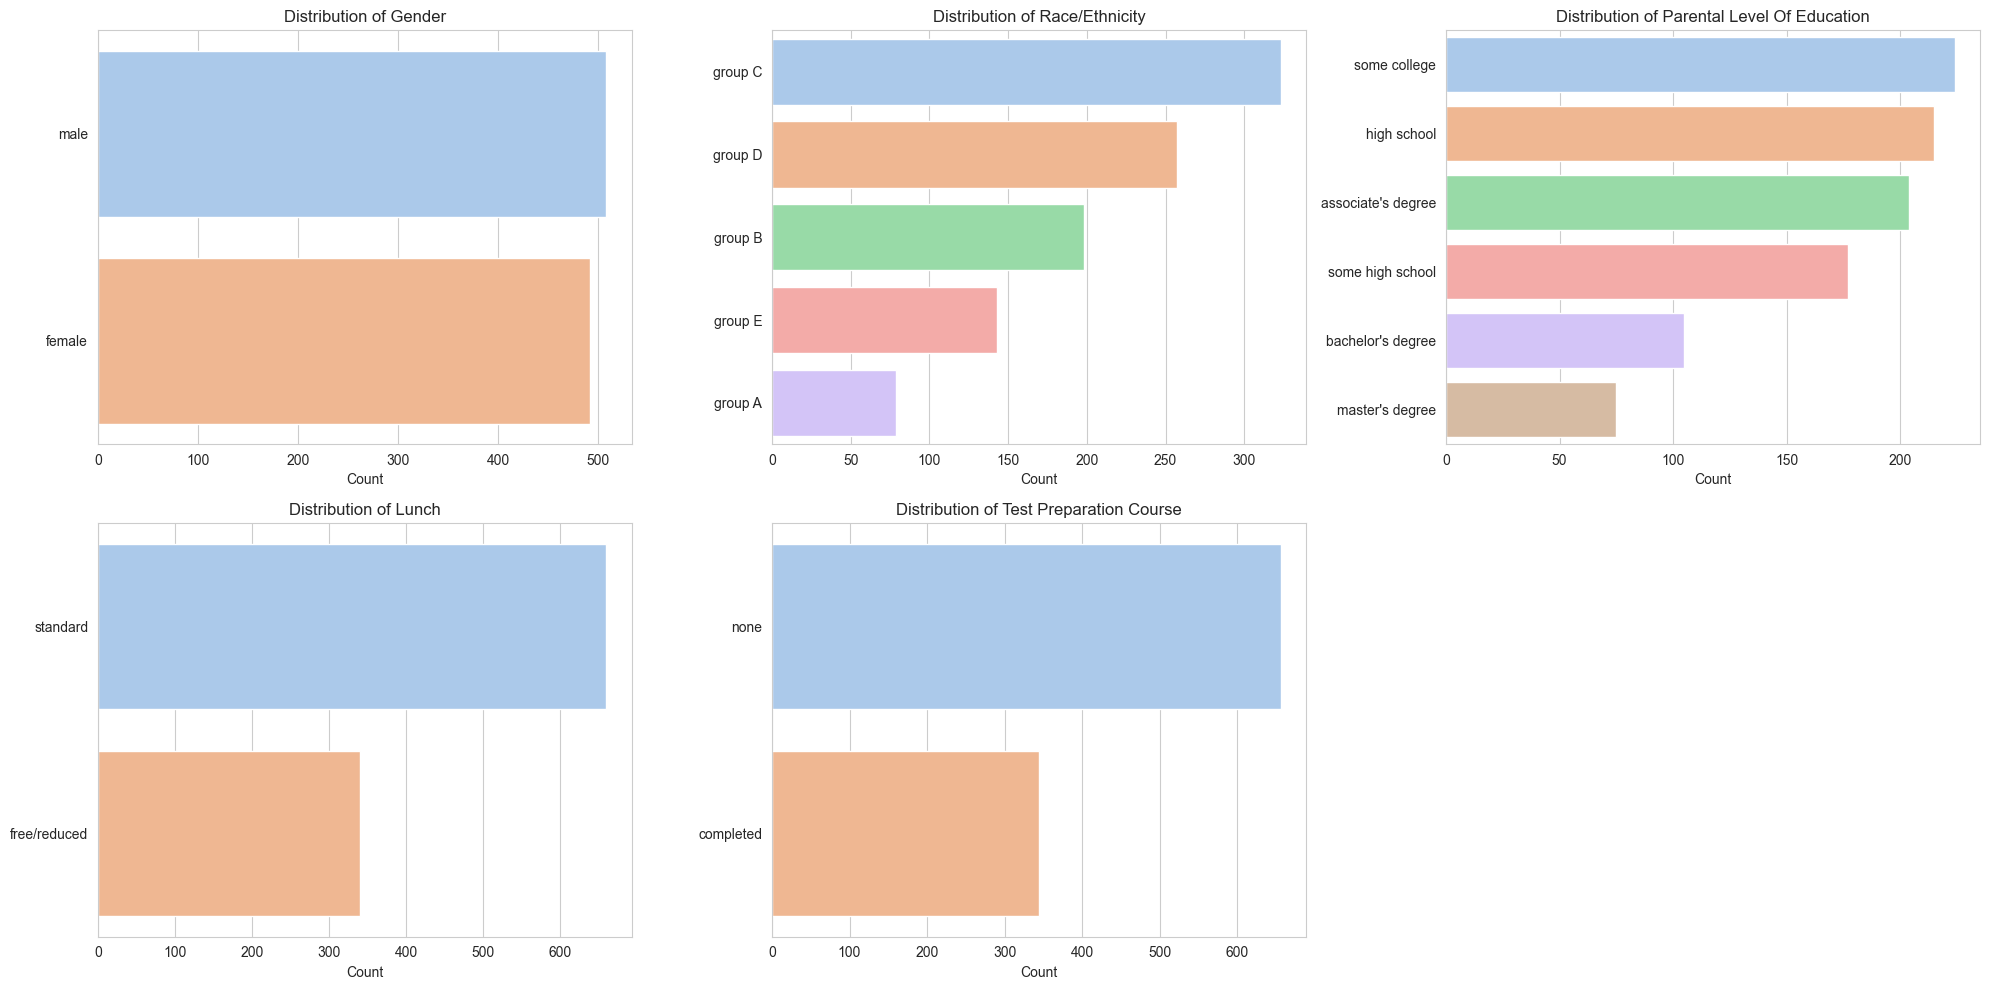

In [12]:
# Distribution of Categorical Features
categorical_cols = df.select_dtypes(include='object').columns
plt.figure(figsize=(20, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(y=col, data=df, palette='pastel', order=df[col].value_counts().index)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel('Count')
    plt.ylabel('')
plt.tight_layout()
plt.show()

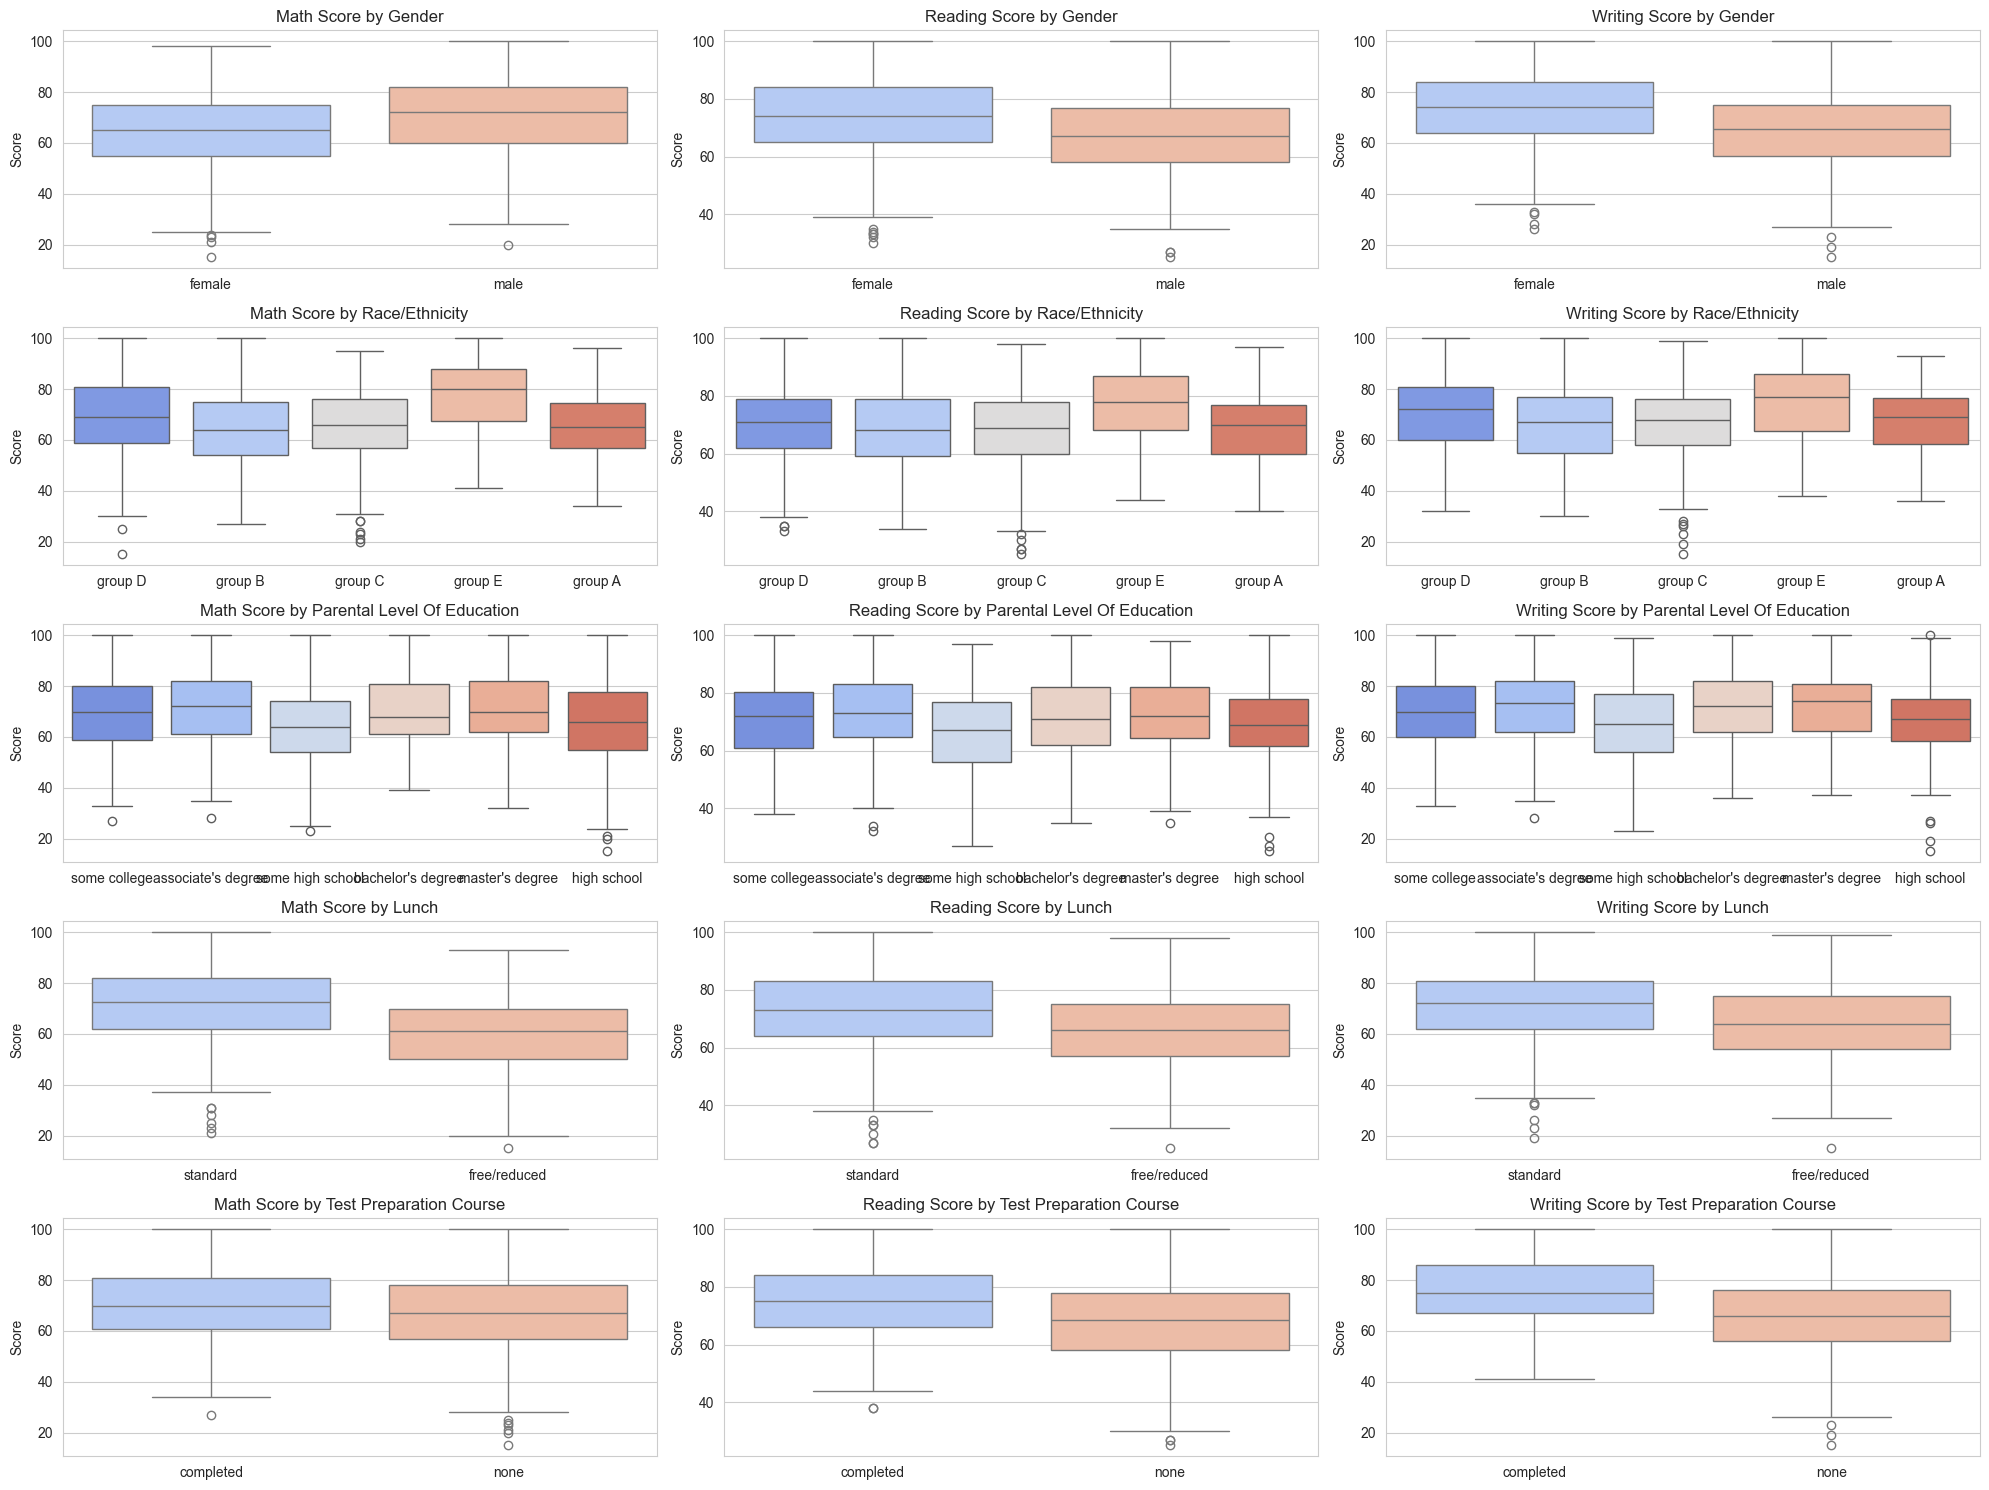

In [13]:
# Relationship between Categorical Features and Scores (Box Plots)
plt.figure(figsize=(20, 15))
score_cols = ['math_score', 'reading_score', 'writing_score']
for i, cat_col in enumerate(categorical_cols):
    for j, score_col in enumerate(score_cols):
        plt.subplot(len(categorical_cols), len(score_cols), i * len(score_cols) + j + 1)
        sns.boxplot(x=cat_col, y=score_col, data=df, palette='coolwarm')
        plt.title(f'{score_col.replace("_", " ").title()} by {cat_col.replace("_", " ").title()}')
        plt.xlabel('')
        plt.ylabel('Score')
plt.tight_layout()
plt.show()

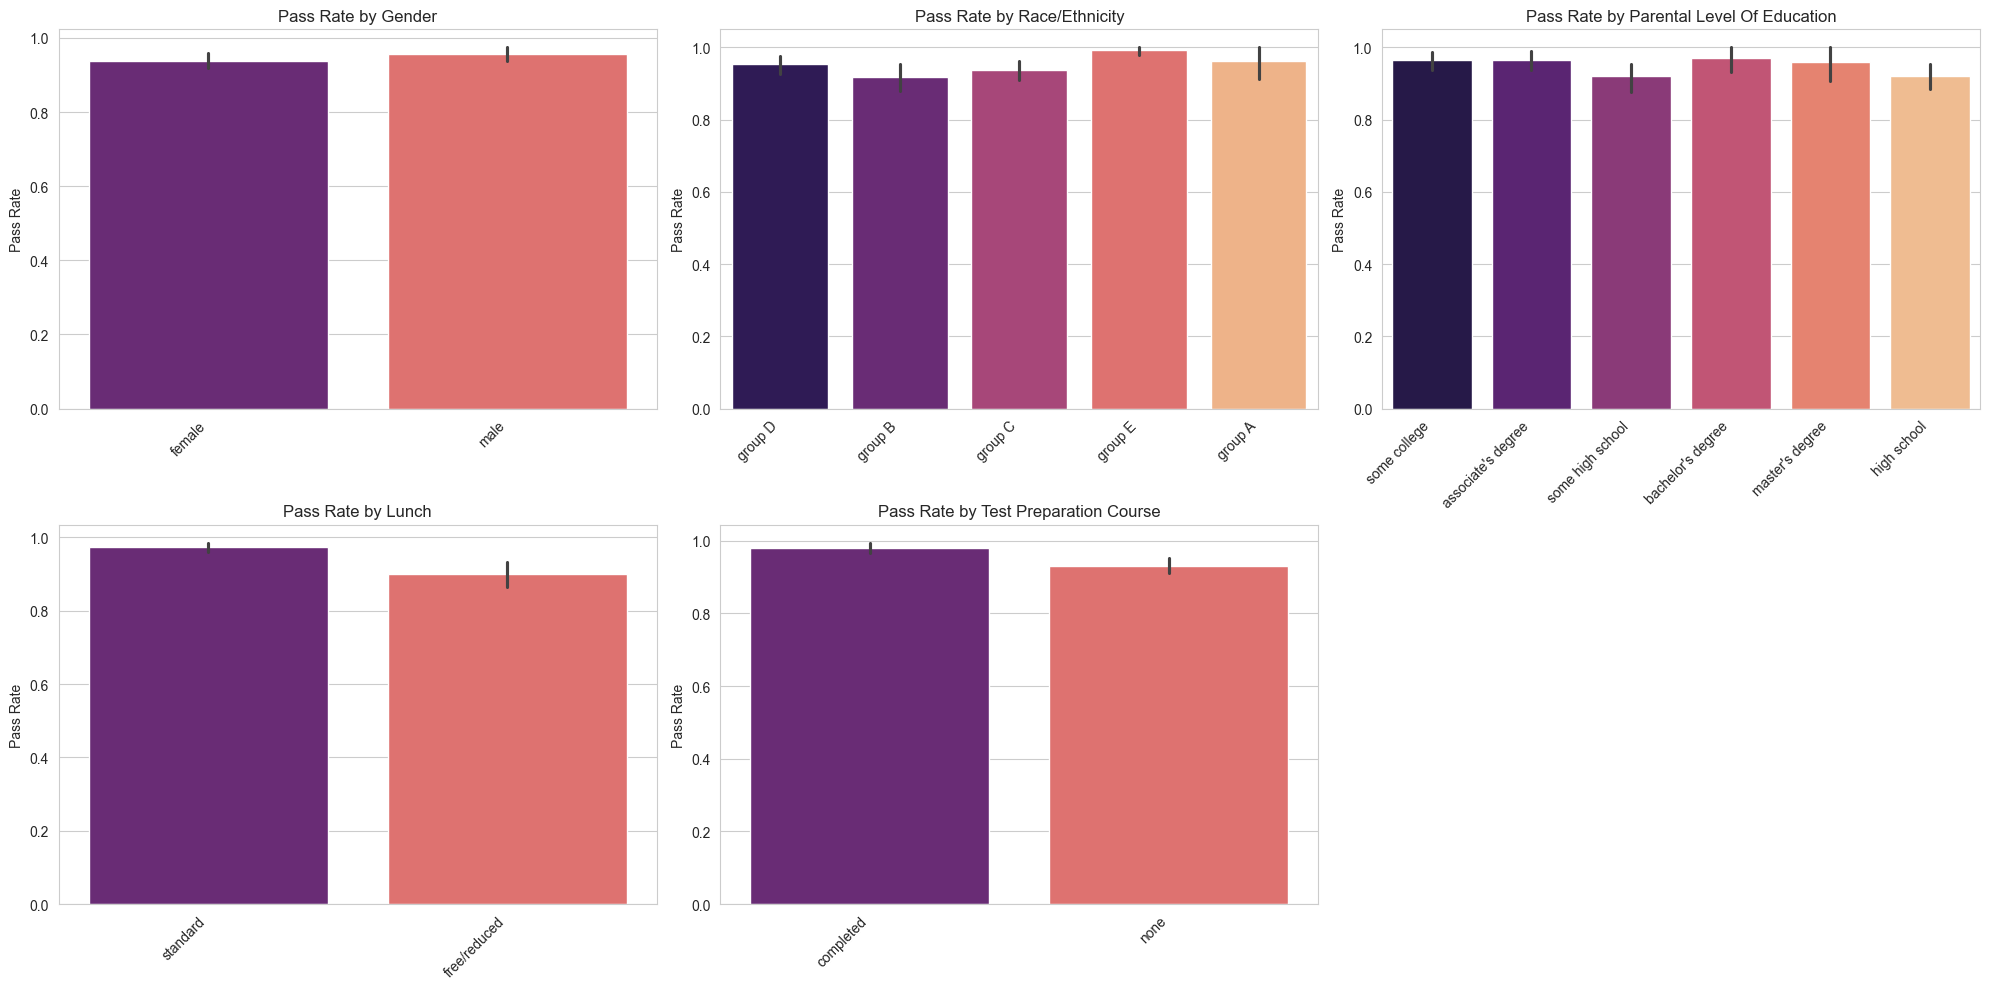

In [25]:
# Relationship between Categorical Features and 'Pass' rate
plt.figure(figsize=(20, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.barplot(x=col, y='pass', data=df, palette='magma')
    plt.title(f'Pass Rate by {col.replace("_", " ").title()}')
    plt.xlabel('')
    plt.ylabel('Pass Rate')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

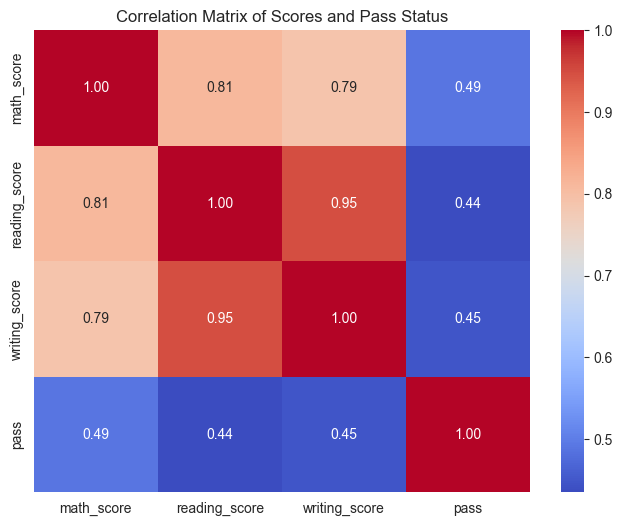

In [15]:
# Correlation Matrix for Numerical Features
plt.figure(figsize=(8, 6))
sns.heatmap(df[score_cols + ['pass']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scores and Pass Status')
plt.show()

### Data Preparation for Modeling

In [16]:
# Separate features (X) and target (y)
X = df.drop('pass', axis=1)
y = df['pass']

In [17]:
# Identify numerical and categorical features for transformation
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

In [18]:
# Apply One-Hot Encoding to categorical features
# drop_first=True avoids multicollinearity by dropping the first category
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print(f"One-Hot Encoded categorical features: {categorical_cols}")

One-Hot Encoded categorical features: ['gender', 'race/ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']


In [19]:
# Split the data into training and testing sets (80% train, 20% test)
# stratify=y ensures that the proportion of 'pass' in train and test sets is similar to the original dataset
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data split into training (X_train shape: {X_train.shape}) and testing (X_test shape: {X_test.shape}) sets.")
print(f"Target distribution in training set:\n{y_train.value_counts(normalize=True)}")
print(f"Target distribution in test set:\n{y_test.value_counts(normalize=True)}")

Data split into training (X_train shape: (800, 15)) and testing (X_test shape: (200, 15)) sets.
Target distribution in training set:
pass
1    0.9475
0    0.0525
Name: proportion, dtype: float64
Target distribution in test set:
pass
1    0.95
0    0.05
Name: proportion, dtype: float64


In [20]:
# Apply StandardScaler to numerical features
# Fit scaler only on training data to prevent data leakage from the test set
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print(f"Numerical features scaled using StandardScaler: {numerical_cols}")

Numerical features scaled using StandardScaler: ['math_score', 'reading_score', 'writing_score']


In [21]:
# Apply SMOTE (Synthetic Minority Over-sampling Technique) to the training data to handle class imbalance
# SMOTE is applied only on the training set to avoid information leakage from the test set
print("Applying SMOTE to training data for imbalance handling...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Original training set shape: {X_train.shape}, Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set target distribution:\n{y_train_resampled.value_counts(normalize=True)}")


Applying SMOTE to training data for imbalance handling...
Original training set shape: (800, 15), Resampled training set shape: (1516, 15)
Resampled training set target distribution:
pass
1    0.5
0    0.5
Name: proportion, dtype: float64


### Model Training and Evaluation

In [22]:
# Function to evaluate models and print key performance metrics
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class

    print(f"\n📊 {name} Performance:")
    print(f"Accuracy     : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision    : {precision_score(y_test, y_pred):.4f}")
    print(f"Recall       : {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score     : {f1_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Initialize various classification models with a fixed random_state for reproducibility
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "XGBoost Classifier": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), # eval_metric specified for XGBoost
    "Decision Tree Classifier": DecisionTreeClassifier(random_state=42)
}

In [23]:
# Train and evaluate each model
trained_models = {} # Dictionary to store trained models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_resampled, y_train_resampled) # Train on SMOTE-resampled training data
    trained_models[name] = model # Store the trained model
    evaluate_model(name, model, X_test, y_test) # Evaluate on the original, unresampled test data




Training Logistic Regression...

📊 Logistic Regression Performance:
Accuracy     : 0.9700
Precision    : 0.9894
Recall       : 0.9789
F1 Score     : 0.9841
ROC AUC Score: 0.9953

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.99      0.98      0.98       190

    accuracy                           0.97       200
   macro avg       0.83      0.89      0.86       200
weighted avg       0.97      0.97      0.97       200


Confusion Matrix:
[[  8   2]
 [  4 186]]

Training Random Forest Classifier...

📊 Random Forest Classifier Performance:
Accuracy     : 0.9850
Precision    : 0.9895
Recall       : 0.9947
F1 Score     : 0.9921
ROC AUC Score: 0.9971

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.99      0.99      0.99       190

    accuracy                           0.98       2

In [24]:
# --- Hyperparameter Tuning Example (Random Forest Classifier) ---
# This section demonstrates how to use GridSearchCV for hyperparameter tuning to find the best model parameters.
print("\n--- Hyperparameter Tuning Example (Random Forest Classifier) ---")

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],      # Number of trees in the forest
    'max_depth': [10, 20, None],     # Maximum depth of the tree
    'min_samples_split': [2, 5],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]       # Minimum number of samples required to be at a leaf node
}
# Initialize GridSearchCV
# cv=3 for 3-fold cross-validation
# scoring='f1' is chosen as a metric to optimize for, especially useful with imbalanced datasets
# n_jobs=-1 uses all available CPU cores
# verbose=1 prints progress messages
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for Random Forest Classifier...")
grid_search.fit(X_train_resampled, y_train_resampled) # Fit GridSearchCV on the resampled training data

print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

best_rf_model = grid_search.best_estimator_ # Get the best model from GridSearchCV
evaluate_model("Random Forest Classifier (Tuned)", best_rf_model, X_test, y_test) # Evaluate the tuned model




--- Hyperparameter Tuning Example (Random Forest Classifier) ---
Starting GridSearchCV for Random Forest Classifier...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters found by GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

📊 Random Forest Classifier (Tuned) Performance:
Accuracy     : 0.9800
Precision    : 0.9895
Recall       : 0.9895
F1 Score     : 0.9895
ROC AUC Score: 0.9974

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.99      0.99      0.99       190

    accuracy                           0.98       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.98      0.98      0.98       200


Confusion Matrix:
[[  8   2]
 [  2 188]]
